# Note
> Pada model ini akan di buat klasifikasi fresh vs rotten

> Dengan menggabungkan database dari buah yang ada di dataset di satukan menjadi 2 kategori besar yaitu rotten dan fresh

> Kategori buah yang di gunakan pada dataset kali ini adalah 
> 1. Apel
> 2. Pisang
> 3. Jeruk

> Reshape ukuran foto yang kita gunakan adalah 100 x 100

> X / 1 = Fresh

> Y / 0 = Rotten

In [5]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

mkdir: cannot create directory ‘./kaggle’: File exists


In [6]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [7]:
! kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification


100% 3.58G/3.58G [00:21<00:00, 210MB/s]
100% 3.58G/3.58G [00:21<00:00, 179MB/s]


In [8]:
!unzip -q fruits-fresh-and-rotten-for-classification.zip -d images


In [12]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from random import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [13]:
def load_rand():
    X=[]
    dir_path='/content/images/dataset/train'
    for sub_dir in tqdm(os.listdir(dir_path)):
        print(sub_dir)
        path_main=os.path.join(dir_path,sub_dir)
        i=0
        for img_name in os.listdir(path_main):
            if i>=6:
                break
            img=cv2.imread(os.path.join(path_main,img_name))
            img=cv2.resize(img,(100,100))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            X.append(img)
            i+=1
    return X
    

In [14]:
X=load_rand()

100%|██████████| 6/6 [00:00<00:00, 30.25it/s]

rottenoranges
freshoranges
freshbanana
rottenbanana
freshapples
rottenapples


In [15]:
X=np.array(X)
X.shape

(36, 100, 100, 3)

In [16]:
def show_subpot(X,title=False,Y=None):
    if X.shape[0]==36:
        f, ax= plt.subplots(6,6, figsize=(40,60))
        list_fruits=['rottenoranges', 'rottenapples', 'freshbanana', 'freshoranges', 'rottenbanana', 'freshapples']
        for i,img in enumerate(X):
            ax[i//6][i%6].imshow(img, aspect='auto')
            if title==False:
                ax[i//6][i%6].set_title(list_fruits[i//6])
            elif title and Y is not None:
                ax[i//6][i%6].set_title(Y[i])
        plt.show()
    else:
        print('Cannot plot')

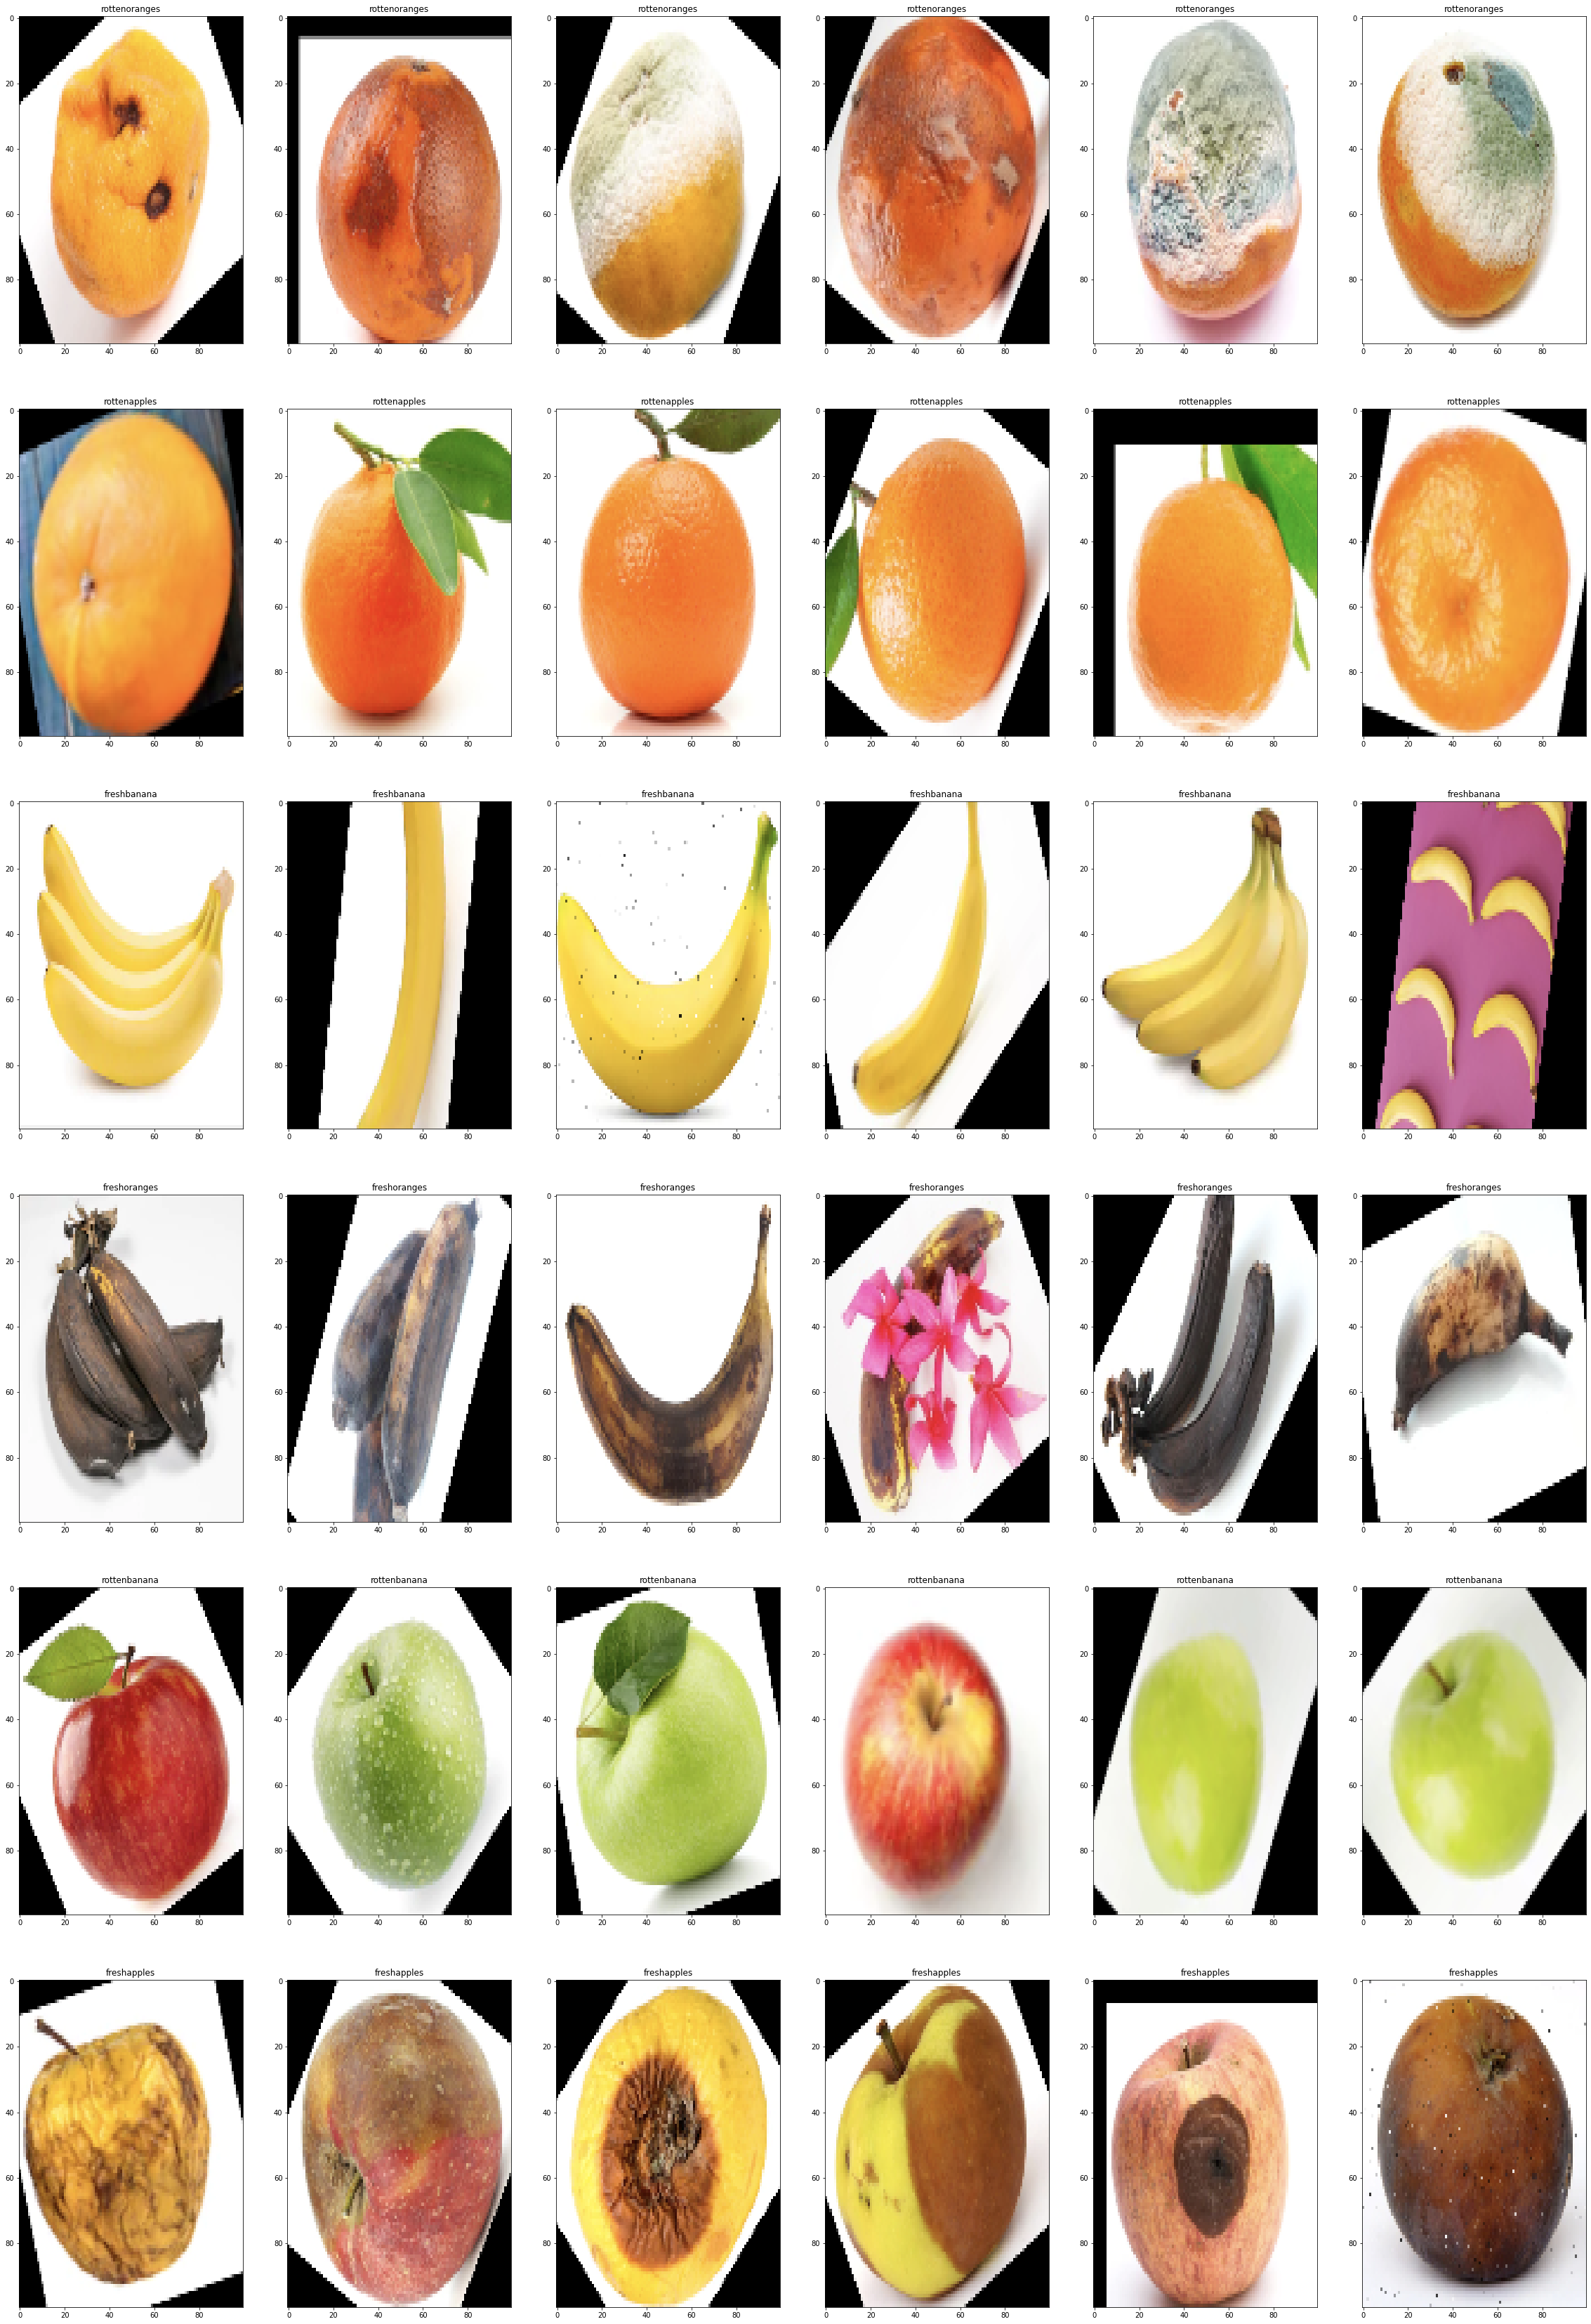

In [17]:
show_subpot(X)

In [18]:
del X

# Rotten vs Fresh

In [19]:
train_path = '/content/images/dataset/train'

In [20]:
print('train set: \n' + '='*50)
num_fresh_apples = len(os.listdir(os.path.join(train_path, 'freshapples')))
num_fresh_banana = len(os.listdir(os.path.join(train_path, 'freshbanana')))
num_fresh_oranges = len(os.listdir(os.path.join(train_path, 'freshoranges')))
num_rotten_apples = len(os.listdir(os.path.join(train_path, 'rottenapples')))
num_rotten_banana = len(os.listdir(os.path.join(train_path, 'rottenbanana')))
num_rotten_oranges = len(os.listdir(os.path.join(train_path, 'rottenoranges')))
print(f'fresh apples = {num_fresh_apples}', 'images')
print(f'fresh banana = {num_fresh_banana}', 'images')
print(f'fresh oranges = {num_fresh_oranges}', 'images')
print(f'rotten apples = {num_rotten_apples}', 'images')
print(f'rotten banana = {num_rotten_banana}', 'images')
print(f'rotten oranges = {num_rotten_oranges}', 'images')

train set: 
fresh apples = 1693 images
fresh banana = 1581 images
fresh oranges = 1466 images
rotten apples = 2342 images
rotten banana = 2224 images
rotten oranges = 1595 images


In [21]:
train_fresh_apple = glob.glob(train_path+"/freshapples/*.png")
train_fresh_banana = glob.glob(train_path+"/freshbanana/*.png")
train_fresh_oranges = glob.glob(train_path+"/freshoranges/*.png")
train_rot_apples = glob.glob(train_path+"/rottenapples/*.png")
train_rot_banana = glob.glob(train_path+"/rottenbanana/*.png")
train_rot_orange = glob.glob(train_path+"/rottenoranges/*.png")

In [22]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_fresh_apple + train_fresh_banana + train_fresh_oranges + train_rot_apples + train_rot_banana + train_rot_orange)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [23]:
print(train_df.shape)
train_df.head()

(10901, 2)


,images,label
0,/content/images/dataset/train/rottenapples/Scr...,rottenapples
1,/content/images/dataset/train/freshbanana/tran...,freshbanana
2,/content/images/dataset/train/rottenbanana/rot...,rottenbanana
3,/content/images/dataset/train/rottenoranges/ro...,rottenoranges
4,/content/images/dataset/train/rottenbanana/rot...,rottenbanana


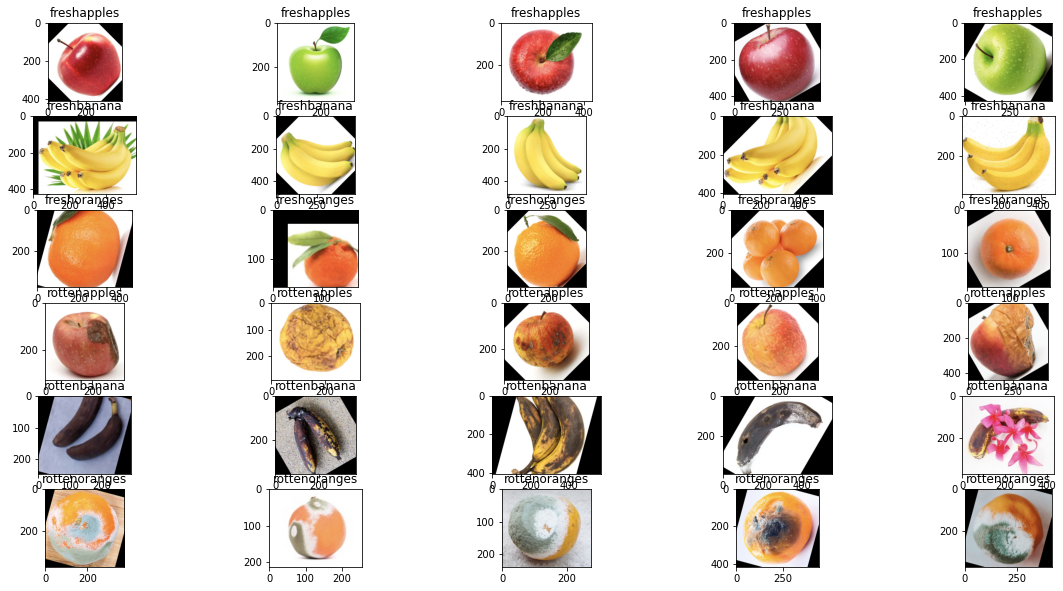

In [24]:
# Get few samples for both the classes
fresh_samples_apple = (train_df[train_df['label']=="freshapples"]['images'].iloc[:5]).tolist()
fresh_samples_banana = (train_df[train_df['label']=="freshbanana"]['images'].iloc[:5]).tolist()
fresh_samples_orange = (train_df[train_df['label']=="freshoranges"]['images'].iloc[:5]).tolist()
rotten_samples_apple = (train_df[train_df['label']=='rottenapples']['images'].iloc[:5]).tolist()
rotten_samples_banana = (train_df[train_df['label']=='rottenbanana']['images'].iloc[:5]).tolist()
rotten_samples_oranges = (train_df[train_df['label']=='rottenoranges']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(fresh_samples_apple + fresh_samples_banana + fresh_samples_orange + rotten_samples_apple + rotten_samples_banana + rotten_samples_oranges)

In [25]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1, stratify = train_df['label'])
print(train_df.shape)
print(val_df.shape)

(8720, 2)
(2181, 2)


In [26]:
img_height= 210
img_width= 210
SEED = 1
BATCH = 256

In [27]:
train_datagen_pipe = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

ds_train_pipe = train_datagen_pipe.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_val_pipe = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)


Found 8720 validated image filenames belonging to 6 classes.
Found 2181 validated image filenames belonging to 6 classes.


In [28]:
ds_train_pipe.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [29]:
inputs_sz = (img_height, img_width, 3)

In [30]:
model_1= Sequential()

#Conv 1, 
model_1.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape=(inputs_sz)))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 3
model_1.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

#Conv 4
model_1.add(Conv2D(filters=256, kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Flatten())
model_1.add(Dense(units=128 , activation='relu'))
model_1.add(Dense(units=6, activation='softmax'))

In [ ]:
# import keras 
# from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, BatchNormalization, SeparableConv2D
# from keras.models import Sequential

# Modeling

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu', input_shape=(100,100,3)))
# model.add(BatchNormalization())
# model.add(SeparableConv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(SeparableConv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.4))

# model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# # model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.5))

# model.add(Flatten())

# #model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
# #model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.3))

# model.add(Dense(6, activation='softmax'))

In [31]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 208, 208, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 104, 104, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 102, 102, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 256)      0

In [ ]:
import tensorflow as tf

In [32]:
lr_rate=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='max',
    min_lr=0.00002, cooldown=2)
check_point=tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/rotten_1.h5', monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min')

model_1.compile(loss=tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(lr = 0.001), metrics=['accuracy'])

In [33]:
history=model_1.fit(ds_train_pipe,batch_size=BATCH,validation_data=ds_val_pipe ,epochs= 50,
                 callbacks=[check_point])

Epoch 1/50
35/35 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.3638
Epoch 1: val_loss improved from inf to 0.30287, saving model to /kaggle/working/rotten_1.h5
35/35 [==============================] - 183s 5s/step - loss: 0.4927 - accuracy: 0.3638 - val_loss: 0.3029 - val_accuracy: 0.5993
Epoch 2/50
35/35 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.6719
Epoch 2: val_loss improved from 0.30287 to 0.14811, saving model to /kaggle/working/rotten_1.h5
35/35 [==============================] - 155s 4s/step - loss: 0.2553 - accuracy: 0.6719 - val_loss: 0.1481 - val_accuracy: 0.8537
Epoch 3/50
35/35 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.8119
Epoch 3: val_loss improved from 0.14811 to 0.11220, saving model to /kaggle/working/rotten_1.h5
35/35 [==============================] - 155s 4s/step - loss: 0.1695 - accuracy: 0.8119 - val_loss: 0.1122 - val_accuracy: 0.8757
Epoch 4/50
35/35 [==========================

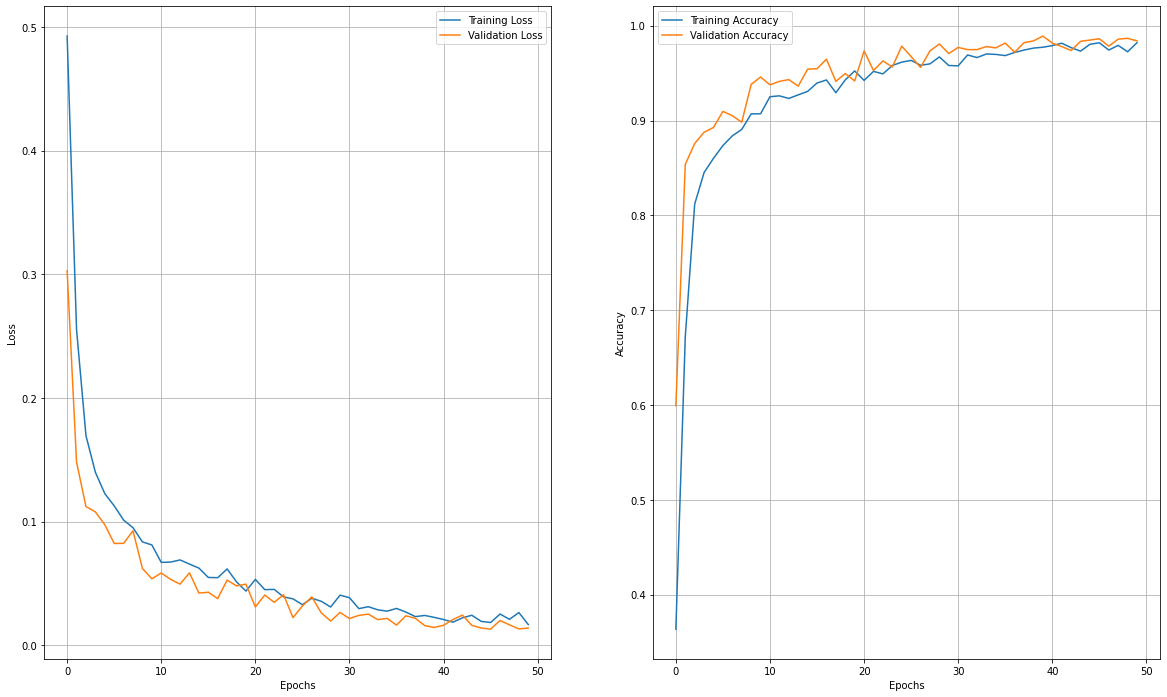

In [34]:
plt.figure(1, figsize = (20, 12))
plt.subplot(1,2,1)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss")
plt.plot( history.history["val_loss"], label = "Validation Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()

In [35]:
model_1.save('/kaggle/working/model9mei.h5')

In [36]:
model_1.save('model9mei.h5')

In [38]:
ds_train_pipe.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [39]:
y_true = ds_val_pipe.classes

In [41]:
test_pred = model_1.predict(ds_val_pipe)

test_pred = np.argmax(test_pred, axis=1)

print(classification_report(y_true, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       339
           1       1.00      1.00      1.00       316
           2       1.00      0.94      0.96       293
           3       0.97      1.00      0.99       469
           4       1.00      1.00      1.00       445
           5       0.94      1.00      0.97       319

    accuracy                           0.98      2181
   macro avg       0.98      0.98      0.98      2181
weighted avg       0.98      0.98      0.98      2181



# model clasifier test